In [1]:
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt

(orig_x_train, orig_y_train), (orig_x_test, orig_y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [2]:
from sklearn.utils import shuffle
orig_x_train, orig_y_train = shuffle(orig_x_train, orig_y_train, random_state=2)
orig_x_test, orig_y_test = shuffle(orig_x_test, orig_y_test, random_state=5)

In [3]:
print("train input shape", orig_x_train.shape)
print("train label shape", orig_y_train.shape)
print("test input shape", orig_x_test.shape)
print("test label shape", orig_y_test.shape)

train input shape (60000, 28, 28)
train label shape (60000,)
test input shape (10000, 28, 28)
test label shape (10000,)


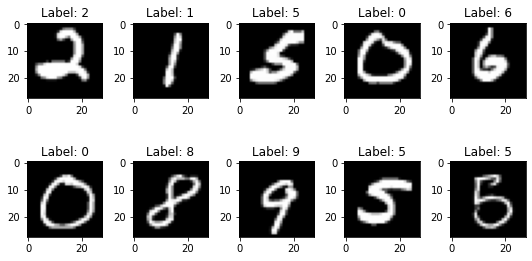

In [4]:
num_row = 2
num_col = 5

num = num_row*num_col
images = orig_x_train[:num]
labels = orig_y_train[:num]

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [5]:
import numpy as np

x_train = np.expand_dims(orig_x_train, 3)
x_test = np.expand_dims(orig_x_test, 3)
print("train input after expand", x_train.shape)
print("test input after expand", x_test.shape)

train input after expand (60000, 28, 28, 1)
test input after expand (10000, 28, 28, 1)


In [6]:
from tensorflow.keras.utils import to_categorical

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print(x_train.shape)
print(x_test.shape)

y_train = to_categorical(orig_y_train, num_classes=10)
y_test = to_categorical(orig_y_test, num_classes=10)
print(y_train.shape)
print(y_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 10)
(10000, 10)


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=15, batch_size=64, validation_data=(x_test, y_test), verbose=0)

In [13]:
for i in range(15):
  print("epoch", i+1)
  print("loss:", history.history['loss'][i])
  print("accuracy:", history.history['accuracy'][i])
  print("val_loss:", history.history['val_loss'][i])
  print("val_accuracy:", history.history['val_accuracy'][i])
  print("******************************************")

epoch 1
loss: 0.1629813015460968
accuracy: 0.9497166872024536
val_loss: 0.042267728596925735
val_accuracy: 0.9854000210762024
******************************************
epoch 2
loss: 0.047506943345069885
accuracy: 0.9849833250045776
val_loss: 0.03418339416384697
val_accuracy: 0.9878000020980835
******************************************
epoch 3
loss: 0.03293447196483612
accuracy: 0.9897666573524475
val_loss: 0.028910400345921516
val_accuracy: 0.9907000064849854
******************************************
epoch 4
loss: 0.02493237517774105
accuracy: 0.9918666481971741
val_loss: 0.04039205610752106
val_accuracy: 0.9879000186920166
******************************************
epoch 5
loss: 0.019795941188931465
accuracy: 0.9940666556358337
val_loss: 0.026055922731757164
val_accuracy: 0.9915000200271606
******************************************
epoch 6
loss: 0.017923099920153618
accuracy: 0.9942333102226257
val_loss: 0.025880971923470497
val_accuracy: 0.9923999905586243
***********************

In [14]:
i = 0
last_conv = None
for l in model.layers:
  if i == 4:
    last_conv = l
    break
  i += 1

print(last_conv.name)  

conv2d_2


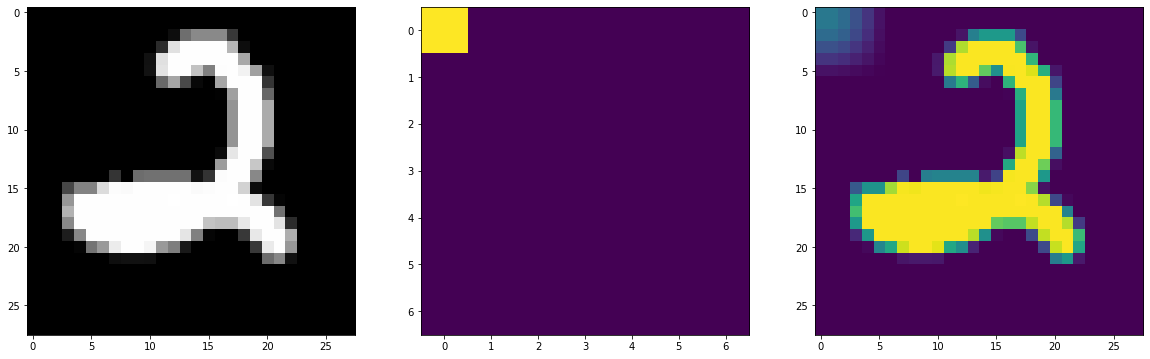

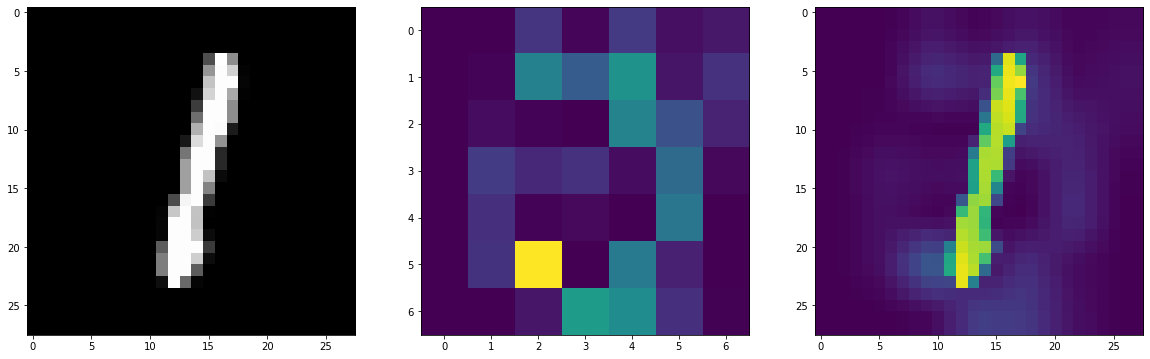

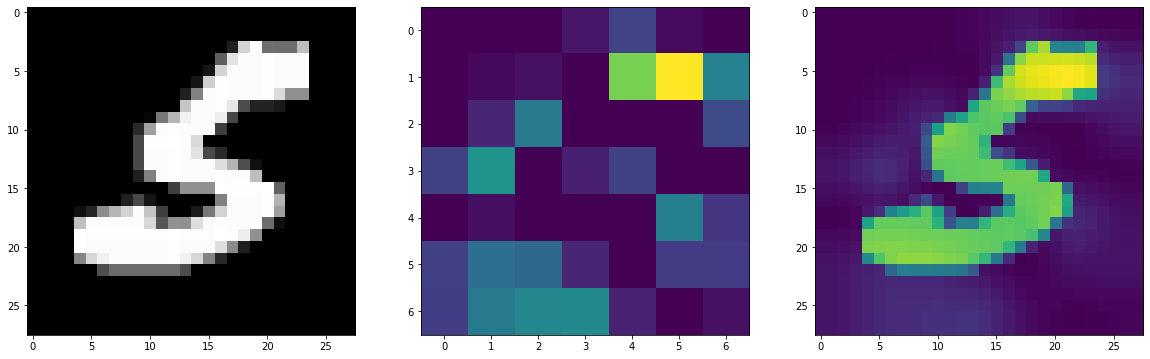

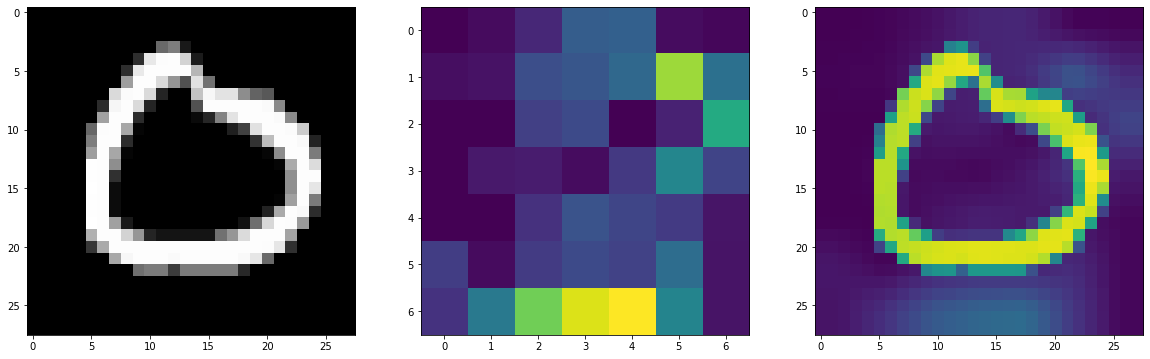

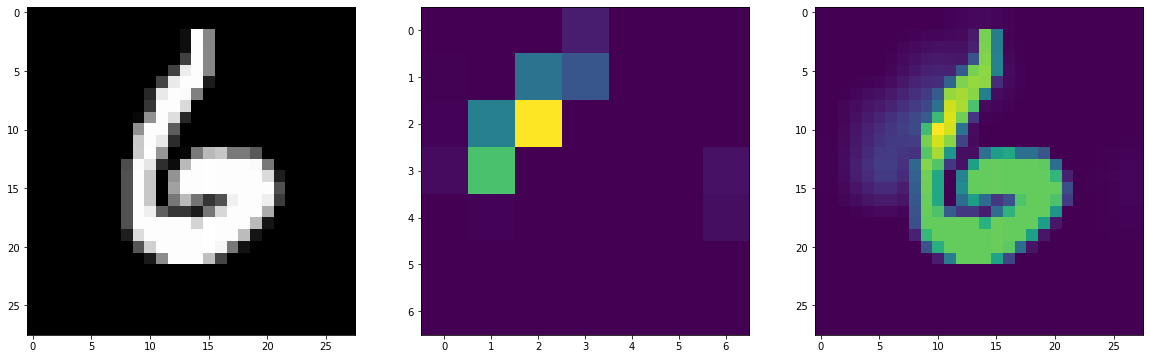

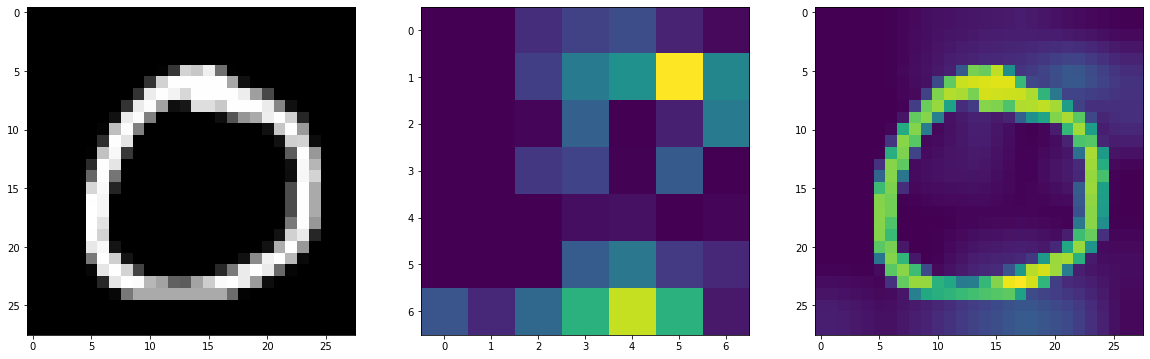

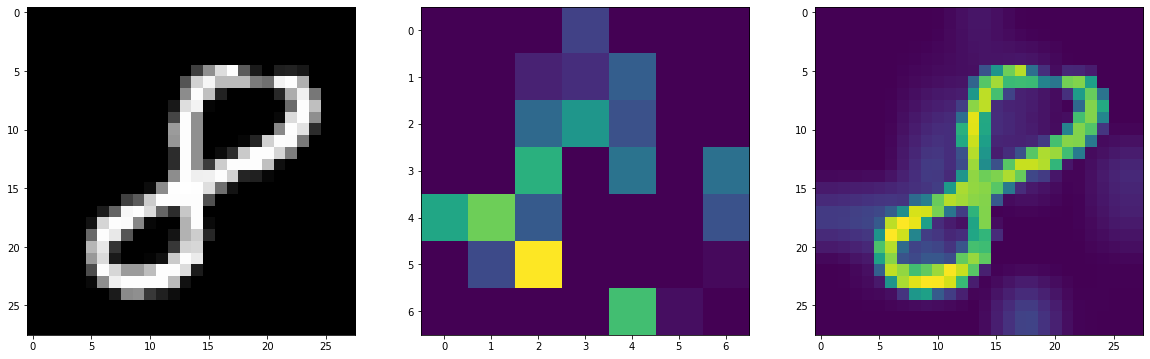

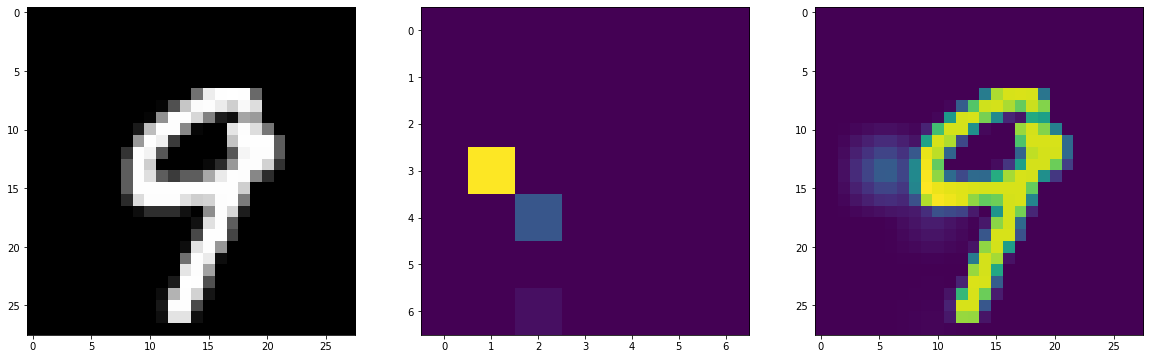

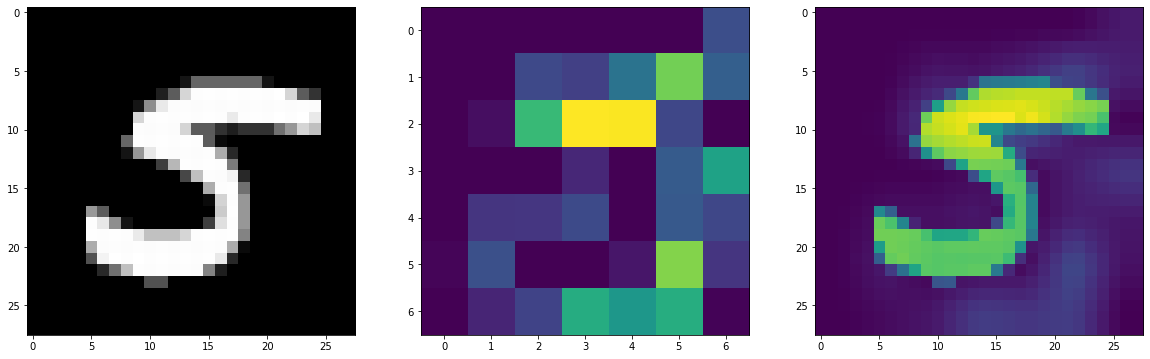

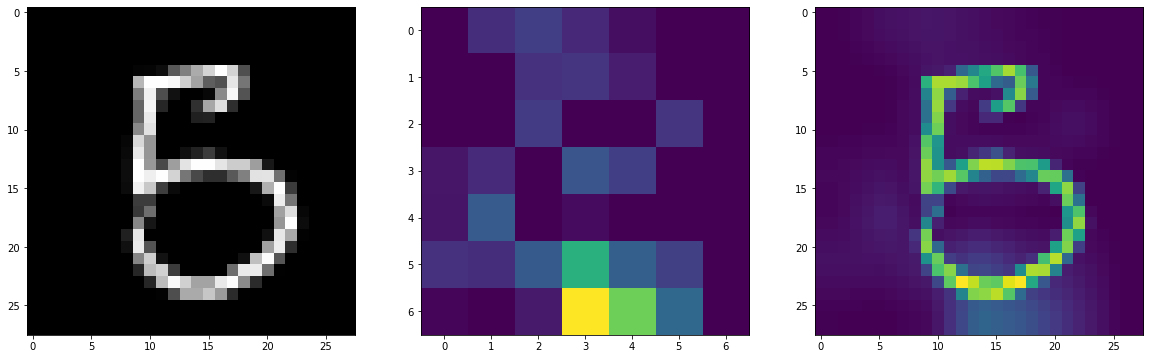

In [16]:
import cv2
from keras import backend as K
from keras import activations
import tensorflow as tf
from tensorflow.keras import models

heatmap_model = models.Model([model.inputs], [last_conv.output, model.output])

for i in range(10):
  img = orig_x_train[i]
  sample = x_train[i]
  sample = np.expand_dims(sample, 0)

  # compute heatmap
  with tf.GradientTape() as gtape:
      conv_output, predictions = heatmap_model(sample)
      loss = predictions[:, np.argmax(predictions[0])]
      grads = gtape.gradient(loss, conv_output)
      pooled_grads = K.mean(grads, axis=(0, 1, 2))

  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
  heatmap = np.maximum(heatmap, 0)
  max_heat = np.max(heatmap)
  if max_heat == 0:
      max_heat = 1e-10
  heatmap /= max_heat
  heatmap = np.squeeze(heatmap)

  # add heatmap to image
  heat = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heat = np.uint8(255*heat)
  superimposed = heat * 0.4 + img

  # plot
  fig, ax = plt.subplots(1, 3)
  fig.set_size_inches(20,20)

  ax[0].imshow(img, cmap="gray")
  ax[1].imshow(heatmap)
  ax[2].imshow(superimposed)
